In [1]:
# ============================================================================
# SECTION 1: ENVIRONMENT SETUP
# ============================================================================

!pip install -q torch torchvision torchaudio
!pip install -q diffusers transformers accelerate
!pip install -q pillow matplotlib
!pip install -q pycocotools
!pip install -q ftfy regex tqdm

print("✓ All packages installed successfully!\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
✓ All packages installed successfully!



In [2]:
# ============================================================================
# SECTION 2: IMPORTS
# ============================================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CocoCaptions

import json
import os
import requests
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers import StableDiffusionPipeline

print("✓ All imports successful!\n")

✓ All imports successful!



In [3]:
# ============================================================================
# SECTION 3: DOWNLOAD & SETUP COCO DATASET (5K SUBSET)
# ============================================================================

print("=" * 80)
print("DOWNLOADING COCO DATASET")
print("=" * 80)

# Create directories
os.makedirs("coco_data", exist_ok=True)
os.chdir("coco_data")

# Download COCO 2017 validation set (smaller, ~5k images)
print("Downloading COCO validation images (1GB)...")
if not os.path.exists("val2017.zip"):
    !wget -q http://images.cocodataset.org/zips/val2017.zip
    !unzip -q val2017.zip
    print("✓ Images extracted")
else:
    print("✓ Images already exist")

# Download annotations
print("Downloading COCO annotations...")
if not os.path.exists("annotations_trainval2017.zip"):
    !wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip -q annotations_trainval2017.zip
    print("✓ Annotations extracted")
else:
    print("✓ Annotations already exist")

os.chdir("..")
print("\n✓ Dataset setup complete!\n")

DOWNLOADING COCO DATASET
✓ Images extracted
✓ Annotations extracted

✓ Dataset setup complete!



In [4]:
# ============================================================================
# SECTION 4: CUSTOM DATASET CLASS
# ============================================================================

class COCOSubset(Dataset):
    """Custom COCO dataset that loads a subset of images with captions"""

    def __init__(self, root_dir, ann_file, num_samples=5000, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load annotations
        with open(ann_file, 'r') as f:
            self.coco_data = json.load(f)

        # Create image_id to captions mapping
        self.img_to_captions = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            caption = ann['caption']
            if img_id not in self.img_to_captions:
                self.img_to_captions[img_id] = []
            self.img_to_captions[img_id].append(caption)

        # Get subset of images
        self.images = self.coco_data['images'][:num_samples]

        print(f"✓ Loaded {len(self.images)} images with captions")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info['id']
        img_filename = img_info['file_name']

        # Load image
        img_path = os.path.join(self.root_dir, img_filename)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Get captions (select first one for simplicity)
        captions = self.img_to_captions.get(img_id, [""])
        caption = captions[0] if captions else ""

        return {
            'image': image,
            'caption': caption,
            'image_id': img_id
        }

In [5]:
# ============================================================================
# SECTION 5: DATA PREPROCESSING & LOADING
# ============================================================================

print("=" * 80)
print("PREPROCESSING DATASET")
print("=" * 80)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Create dataset (using 5000 samples)
dataset = COCOSubset(
    root_dir='coco_data/val2017',
    ann_file='coco_data/annotations/captions_val2017.json',
    num_samples=5000,
    transform=transform
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

print(f"✓ Dataset size: {len(dataset)}")
print(f"✓ Number of batches: {len(dataloader)}\n")

PREPROCESSING DATASET
✓ Loaded 5000 images with captions
✓ Dataset size: 5000
✓ Number of batches: 1250



VISUALIZING SAMPLE DATA


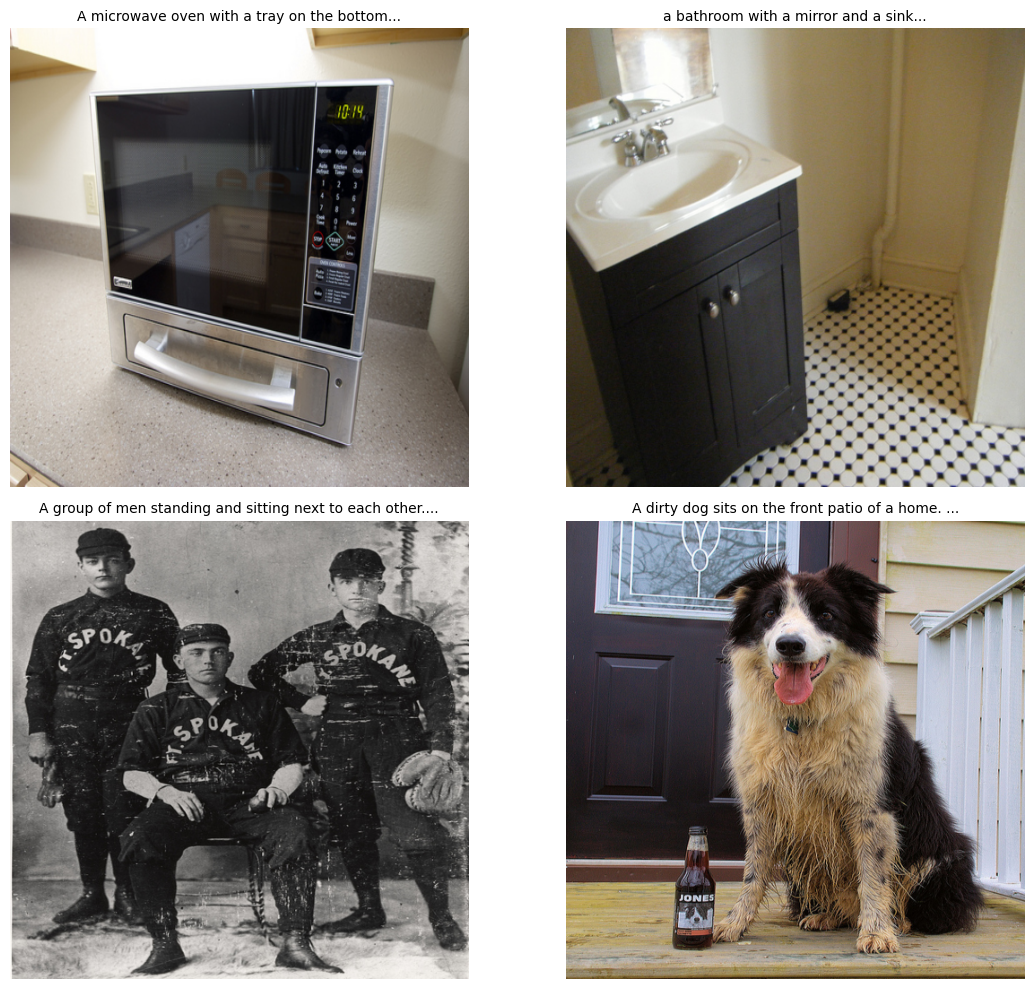

✓ Sample visualization saved as 'sample_coco_data.png'



In [6]:
# ============================================================================
# SECTION 6: VISUALIZE SAMPLE DATA
# ============================================================================

print("=" * 80)
print("VISUALIZING SAMPLE DATA")
print("=" * 80)

# Get a sample batch
sample = next(iter(dataloader))
images = sample['image']
captions = sample['caption']

# Display first 4 images with captions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(4):
    img = images[i].permute(1, 2, 0).numpy()
    img = (img * 0.5 + 0.5)  # Denormalize
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].set_title(captions[i][:60] + "...", fontsize=10, wrap=True)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('sample_coco_data.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Sample visualization saved as 'sample_coco_data.png'\n")

In [7]:
# ============================================================================
# SECTION 7: SETUP CLIP TEXT ENCODER
# ============================================================================

print("=" * 80)
print("LOADING CLIP MODEL FOR TEXT ENCODING")
print("=" * 80)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# Load CLIP text encoder and tokenizer
model_id = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizer.from_pretrained(model_id)
text_encoder = CLIPTextModel.from_pretrained(model_id)
text_encoder = text_encoder.to(device)
text_encoder.eval()

print("✓ CLIP model loaded successfully!\n")

LOADING CLIP MODEL FOR TEXT ENCODING
Using device: cuda



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

✓ CLIP model loaded successfully!



In [8]:
# ============================================================================
# SECTION 8: TEXT-TO-EMBEDDING BASELINE PIPELINE
# ============================================================================

class TextToEmbeddingPipeline:
    """Baseline pipeline for converting text prompts to embeddings"""

    def __init__(self, tokenizer, text_encoder, device):
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.device = device

    def encode_text(self, prompts):
        """Convert text prompts to embeddings"""
        # Tokenize
        text_inputs = self.tokenizer(
            prompts,
            padding="max_length",
            max_length=77,
            truncation=True,
            return_tensors="pt"
        )

        # Get embeddings
        with torch.no_grad():
            text_embeddings = self.text_encoder(
                text_inputs.input_ids.to(self.device)
            )[0]

        return text_embeddings

    def visualize_embedding(self, prompt, embedding):
        """Visualize embedding statistics"""
        embedding_np = embedding.cpu().numpy().flatten()

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        # Histogram
        axes[0].hist(embedding_np, bins=50, color='steelblue', alpha=0.7)
        axes[0].set_title(f'Embedding Distribution\nPrompt: "{prompt}"')
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Frequency')

        # First 100 values
        axes[1].plot(embedding_np[:100], color='coral', linewidth=1)
        axes[1].set_title('First 100 Embedding Values')
        axes[1].set_xlabel('Dimension')
        axes[1].set_ylabel('Value')
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

# Initialize pipeline
pipeline = TextToEmbeddingPipeline(tokenizer, text_encoder, device)

print("✓ Text-to-Embedding Pipeline initialized!\n")

✓ Text-to-Embedding Pipeline initialized!



TESTING TEXT-TO-EMBEDDING PIPELINE
Processing test prompts...

[1/5] Prompt: 'a cat sitting on a couch'
  → Embedding shape: torch.Size([1, 77, 512])
  → Mean: 0.1238, Std: 1.0720

[2/5] Prompt: 'a beautiful sunset over the ocean'
  → Embedding shape: torch.Size([1, 77, 512])
  → Mean: 0.1184, Std: 1.0626

[3/5] Prompt: 'a person riding a bicycle in the park'
  → Embedding shape: torch.Size([1, 77, 512])
  → Mean: 0.1185, Std: 1.0718

[4/5] Prompt: 'a bowl of fresh fruit on a table'
  → Embedding shape: torch.Size([1, 77, 512])
  → Mean: 0.1135, Std: 1.0425

[5/5] Prompt: 'a dog playing with a ball in the garden'
  → Embedding shape: torch.Size([1, 77, 512])
  → Mean: 0.1223, Std: 1.0634

✓ All test prompts processed!

Visualizing embedding for first prompt...


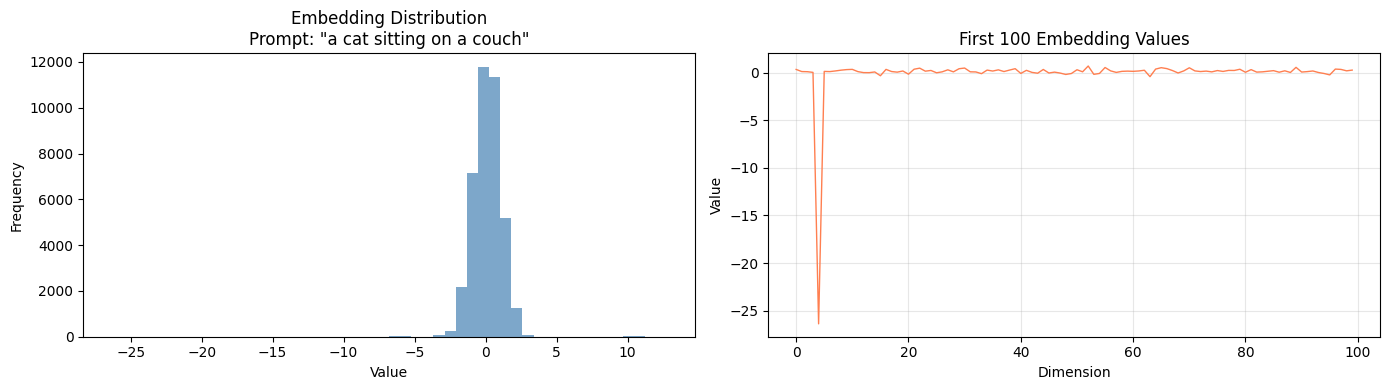

In [9]:
# ============================================================================
# SECTION 9: TEST THE BASELINE PIPELINE
# ============================================================================

print("=" * 80)
print("TESTING TEXT-TO-EMBEDDING PIPELINE")
print("=" * 80)

# Test with 5 sample prompts
test_prompts = [
    "a cat sitting on a couch",
    "a beautiful sunset over the ocean",
    "a person riding a bicycle in the park",
    "a bowl of fresh fruit on a table",
    "a dog playing with a ball in the garden"
]

print("Processing test prompts...\n")

embeddings_results = []

for i, prompt in enumerate(test_prompts, 1):
    print(f"[{i}/5] Prompt: '{prompt}'")

    # Encode prompt
    embedding = pipeline.encode_text([prompt])

    # Store results
    embeddings_results.append({
        'prompt': prompt,
        'embedding': embedding,
        'shape': embedding.shape,
        'mean': embedding.mean().item(),
        'std': embedding.std().item()
    })

    print(f"  → Embedding shape: {embedding.shape}")
    print(f"  → Mean: {embedding.mean().item():.4f}, Std: {embedding.std().item():.4f}\n")

print("✓ All test prompts processed!\n")

# Visualize one embedding
print("Visualizing embedding for first prompt...")
fig = pipeline.visualize_embedding(test_prompts[0], embeddings_results[0]['embedding'])
plt.savefig('embedding_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# ============================================================================
# SECTION 10: LOAD PRETRAINED STABLE DIFFUSION (FOR IMAGE GENERATION)
# ============================================================================

print("=" * 80)
print("LOADING STABLE DIFFUSION MODEL FOR IMAGE GENERATION")
print("=" * 80)

# Load pretrained Stable Diffusion v2.1
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
pipe = pipe.to(device)

print("✓ Stable Diffusion model loaded!\n")


LOADING STABLE DIFFUSION MODEL FOR IMAGE GENERATION


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✓ Stable Diffusion model loaded!



GENERATING IMAGES FROM TEST PROMPTS
[1/5] Generating image for: 'a cat sitting on a couch'


  0%|          | 0/50 [00:00<?, ?it/s]

  ✓ Image generated

[2/5] Generating image for: 'a beautiful sunset over the ocean'


  0%|          | 0/50 [00:00<?, ?it/s]

  ✓ Image generated

[3/5] Generating image for: 'a person riding a bicycle in the park'


  0%|          | 0/50 [00:00<?, ?it/s]

  ✓ Image generated

[4/5] Generating image for: 'a bowl of fresh fruit on a table'


  0%|          | 0/50 [00:00<?, ?it/s]

  ✓ Image generated

[5/5] Generating image for: 'a dog playing with a ball in the garden'


  0%|          | 0/50 [00:00<?, ?it/s]

  ✓ Image generated



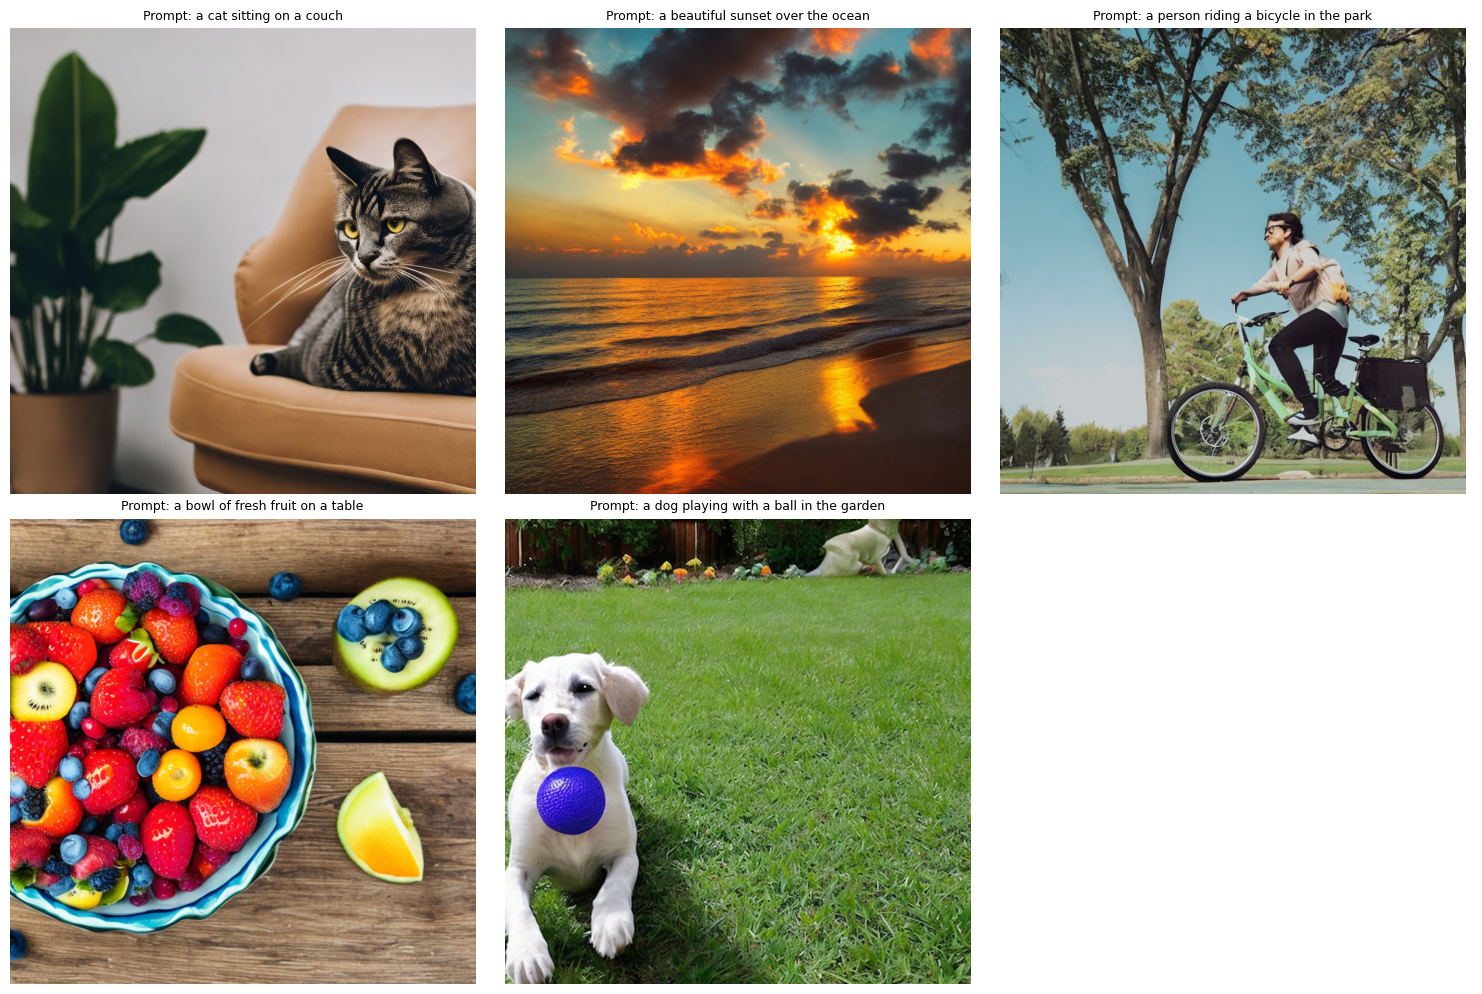

✓ All images generated and saved!



In [14]:
# ============================================================================
# SECTION 11: GENERATE IMAGES FROM TEST PROMPTS
# ============================================================================

print("=" * 80)
print("GENERATING IMAGES FROM TEST PROMPTS")
print("=" * 80)

generated_images = []

for i, prompt in enumerate(test_prompts, 1):
    print(f"[{i}/5] Generating image for: '{prompt}'")

    # Generate image
    with torch.autocast("cuda" if torch.cuda.is_available() else "cpu"):
        image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

    generated_images.append(image)
    print(f"  ✓ Image generated\n")

# Display all generated images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (prompt, img) in enumerate(zip(test_prompts, generated_images)):
    axes[i].imshow(img)
    axes[i].set_title(f"Prompt: {prompt}", fontsize=9, wrap=True)
    axes[i].axis('off')

# Hide the last subplot (we only have 5 images)
axes[5].axis('off')

plt.tight_layout()
plt.savefig('generated_images_all.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ All images generated and saved!\n")


In [15]:
# ============================================================================
# SECTION 12: SAVE RESULTS & SUMMARY
# ============================================================================

print("=" * 80)
print("SAVING RESULTS & SUMMARY")
print("=" * 80)

# Save individual generated images
os.makedirs("generated_images", exist_ok=True)

for i, (prompt, img) in enumerate(zip(test_prompts, generated_images)):
    filename = f"generated_images/test_{i+1}.png"
    img.save(filename)
    print(f"✓ Saved: {filename}")

# Create summary report
summary = {
    "dataset": "COCO val2017",
    "num_samples": len(dataset),
    "model": "Stable Diffusion v1.4",
    "text_encoder": "CLIP ViT-B/32",
    "test_prompts": test_prompts,
    "device": str(device),
    "embedding_dim": embeddings_results[0]['shape'][-1]
}

with open("pipeline_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n✓ Summary saved to 'pipeline_summary.json'")

# ============================================================================
# FINAL OUTPUT
# ============================================================================

print("\n" + "=" * 80)
print("PIPELINE EXECUTION COMPLETE!")
print("=" * 80)
print(f"""
✓ Dataset loaded: {len(dataset)} COCO image-caption pairs
✓ Text-to-embedding pipeline: Working
✓ Image generation: 5 test images created
✓ Results saved in:
  - sample_coco_data.png
  - embedding_visualization.png
  - generated_images_all.png
  - generated_images/ directory
  - pipeline_summary.json
""")
print("=" * 80)

SAVING RESULTS & SUMMARY
✓ Saved: generated_images/test_1.png
✓ Saved: generated_images/test_2.png
✓ Saved: generated_images/test_3.png
✓ Saved: generated_images/test_4.png
✓ Saved: generated_images/test_5.png

✓ Summary saved to 'pipeline_summary.json'

PIPELINE EXECUTION COMPLETE!

✓ Dataset loaded: 5000 COCO image-caption pairs
✓ Text-to-embedding pipeline: Working
✓ Image generation: 5 test images created
✓ Results saved in:
  - sample_coco_data.png
  - embedding_visualization.png
  - generated_images_all.png
  - generated_images/ directory
  - pipeline_summary.json

